# Notebook to visualise results from penalty coefficient experiments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cmcrameri.cm as cm
import numpy as np
import os
from typing import List

In [2]:
### Latex font in plots
plt.rcParams['font.serif'] = "cmr10"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24

plt.rcParams['legend.fontsize'] = 24
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.linewidth'] = 2   # Default for all spines
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.major.size'] = 6  # Thicker major x-ticks
plt.rcParams['xtick.major.width'] = 2  # Thicker major x-
plt.rcParams['ytick.major.size'] = 6  
plt.rcParams['ytick.major.width'] = 2 

plt.rc('axes', unicode_minus=False)


In [3]:
def load_data(path: str, filename: str) -> pd.DataFrame:
    """
    Load data from a file.
    Args:
    - path: the path to the file
    - filename: the name of the file

    Returns:
    - df: the loaded data as a pandas DataFrame
    """
    df = pd.read_csv(os.path.join(path, filename))
    return df

def load_data_folder(path: str) -> pd.DataFrame:
    """
    Load data from a folder.
    Args:
    - path: the path to the folder

    Returns:
    - dfs: a list of pandas DataFrames, each containing the data from a file in the folder
    """
    dfs = []
    for filename in sorted(os.listdir(path)):
        print(filename)
        df = load_data(path, filename)
        dfs.append(df)
    return dfs


In [4]:
def aggregate_data(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Function that computes statistics for violations and profits per episode.
    This function takes in a DataFrame and the name of the column to be used for violations.

    Args:
    - df: the DataFrame
    - column: the name of the column to be used for violations

    Returns:
    - episode: the episode number
    - Profits: the total profits for the episode
    - CO2 Violation Time (%): the percentage of time with CO2 violations
    - CO2 Violation (ppm): the average magnitude of CO2 violations
    """
    # print(df)
    N = (df[df['episode'] == 0]).shape[0]
    profits_per_episode = df[['Profits', 'episode']].groupby('episode').sum().reset_index()
    # CO2 violation time per episode, considering each row as 5 minutes
    co2_violation_time_updated = df[df[column] > 0].groupby('episode').size()/N*100 # % of time with violation
    # print(co2_violation_time_updated)
    # co2_violation_time_updated = 100-co2_violation_time_updated
    # print(co2_violation_time_updated)
    # Average magnitude of CO2 violations per episode, for positive violations only
    # avg_co2_violation_magnitude_updated = df[[column, 'episode']].groupby('episode')[column].sum()
    avg_co2_violation_magnitude_updated = df[df[column] > 0].groupby('episode')[column].mean()
    # Combine the updated results into a summary DataFrame
    summary_df_updated = pd.DataFrame({
        f'Time within boundary (%)': co2_violation_time_updated,
        f'{column} (ppm)': avg_co2_violation_magnitude_updated,
    }).reset_index()

    # add coefficient to resulting 

    # Create a DataFrame of all unique episodes to ensure all are represented
    all_episodes_df = pd.DataFrame(df['episode'].unique(), columns=['episode'])

    # Merge the summary of violations with the complete list of episodes
    # This ensures episodes with no violations are included, filling missing values appropriately
    full_summary_df = pd.merge(all_episodes_df, summary_df_updated, on='episode', how='left').fillna(0)
    # print(full_summary_df['coefficients'])
    full_summary_df = pd.merge(profits_per_episode, full_summary_df, on='episode', how='left').fillna(0)
    full_summary_df['Time within boundary (%)'] = 100- full_summary_df['Time within boundary (%)']

    return full_summary_df

In [5]:
def plot_coef(fig, ax, var_df, std_df, color, var_to_plot, xlabel, ylabel, ylim, marker_idx, marker, linestyle='-', linewidth=4, markersize=10, sci_notation=False, errorbar=False, label=None):
    ax.plot(var_df['ki'], var_df[var_to_plot], linestyle, linewidth=linewidth, markersize=markersize, color=color, label=label)
    if errorbar:
        ax.errorbar(var_df['ki'], var_df[var_to_plot], yerr=std_df[var_to_plot], fmt=linestyle, color=color, linesytle=linestyle, linewidth=linewidth, markersize=markersize, capsize=4, elinewidth=linewidth, markeredgewidth=2)

    if marker_idx:
        # plot black ciricle around 5th point
        ax.plot(var_df['ki'][marker_idx], var_df[var_to_plot][marker_idx], linestyle='None', marker=marker, markersize=markersize+2, markeredgewidth=4, mfc='none', color=cm.tokyoS(0))

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_ylim(ylim)
    ax.set_xticks(np.linspace(0, max(var_df['ki']), 6))  
    if sci_notation:
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,-2))

    # remove top spine
    ax.spines[['right', 'top']].set_visible(False)
    return fig, ax


In [6]:
def experiment_means(dfs: List[pd.DataFrame], ki: np.ndarray, Nseeds: int) -> pd.core.series.Series:
    '''
    Compute the mean of the experiments for each ki
    '''
    df_means = []
    for i, df in enumerate(dfs):
        df = df.mean().drop('episode')
        df['ki'] = ki[i//Nseeds]
        df_means.append(df)
    return df_means

def experiment_stds(dfs: List[pd.DataFrame], ki: np.ndarray, Nseeds: int) -> pd.core.series.Series:
    '''
    Compute the std of the experiments for each ki
    '''
    df_std = []
    for i, df in enumerate(dfs):
        df = df.std().drop('episode')
        df['ki'] = ki[i//Nseeds]
        df_std.append(df)
    return df_std

def ci(std, n, z=1.96):
    return z*std/np.sqrt(n)

def compute_mean_std(dfs, coefficients, variable, Nexprmnts):
    '''
    Compute the mean and std of the experiment for each parameter coefficient ki.
    Do for a specified variable.
    '''
    dfs_stats = [aggregate_data(df, variable) for i, df in enumerate(dfs)]
    dfs_means = experiment_means(dfs_stats, coefficients, Nexprmnts)
    dfs_means = pd.concat(dfs_means, axis=1).T
    dfs_std = experiment_stds(dfs_stats, coefficients, Nexprmnts)
    dfs_std = pd.concat(dfs_std, axis=1).T
    return dfs_means, dfs_std

In [7]:
def experiment_control_means(dfs: List[pd.DataFrame], ki: np.ndarray, Nseeds: int) -> pd.core.series.Series:
    # compute day and night means
    light_threshold = 1e-3

    # assign value column that depicts whether the light is on or off
    # for i in range(len(dfs)):
    df_means = []
    for i, df in enumerate(dfs):
        df['light'] = df['PAR'] > light_threshold
        df = df.groupby('light')[['uVent', 'uCO2', 'uBoil', 'uThScr']].mean().reset_index()

        df['ki'] = ki[i//Nseeds]
        df_means.append(df)
        # print(df.head())

    return df_means

# Carbon dioxide concentration

In [8]:
additive_data_path = '../data/additive-penalty/'
multiplicative_data_path = '../data/multiplicative-penalty-2/'
SEEDS = [666]
Nexperimnts = len(SEEDS)

In [9]:
co2_additive_dfs  = load_data_folder(additive_data_path+'co2/')
co2_multiplicative_dfs  = load_data_folder(multiplicative_data_path+'co2/')

k-co2-0.0-666.csv


k-co2-0.002-666.csv
k-co2-0.004-666.csv
k-co2-0.006-666.csv
k-co2-0.008-666.csv
k-co2-0.01-666.csv
k-co2-0.0-666.csv
k-co2-0.002-666.csv
k-co2-0.004-666.csv
k-co2-0.006-666.csv
k-co2-0.008-666.csv
k-co2-0.01-666.csv


In [10]:
co2_variable = 'CO2 violation'
co2_coefficients = np.linspace(0,1e-2, 6)
co2_additive_means, co2_additive_stds = compute_mean_std(co2_additive_dfs, co2_coefficients, co2_variable, Nexperimnts)
co2_multiplicative_means, co2_multiplicative_stds = compute_mean_std(co2_multiplicative_dfs, co2_coefficients, co2_variable, Nexperimnts)


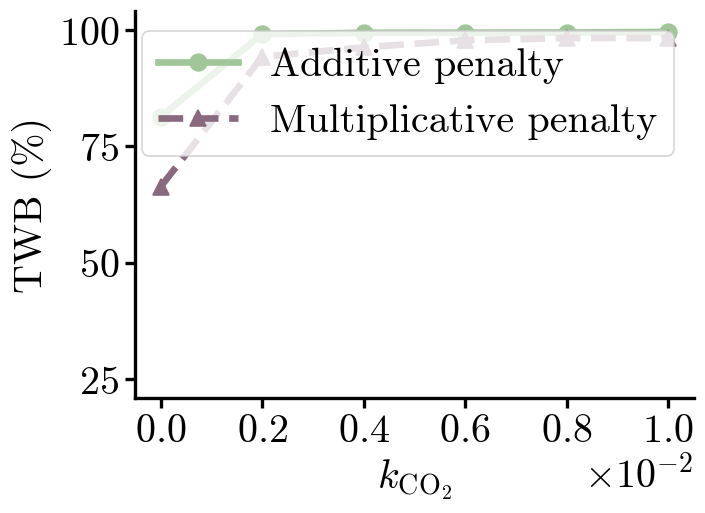

In [11]:
additive_color = cm.tokyoS(4)
multiplicative_color = cm.tokyoS(6)
additive_linestyle = 'o-'
multiplicative_linestyle = '^--'
co2_marker_idx = None
ylim = (20.952141203703697, 104)
var_to_plot = 'Time within boundary (%)'
co2_xlabel = r'$k_{\mathrm{CO}_2}$'
additive_marker = 'o'
multiplicative_marker = '^'
bound_ylabel = r'TWB (%)'
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)

additive_plot_params = {'fig': fig, 'ax': ax, 'var_df': co2_additive_means, 'std_df': co2_additive_stds,'color': additive_color, 'var_to_plot': var_to_plot, 'xlabel': co2_xlabel, 'marker': additive_marker, 'ylabel':bound_ylabel, 'ylim':ylim, 'marker_idx': co2_marker_idx, 'linestyle': additive_linestyle, 'marker_idx': co2_marker_idx, 'linewidth': 4, 'markersize': 10, 'sci_notation': True, 'errorbar': False, 'label':'Additive penalty'}
multiplicative_plot_params = additive_plot_params.copy()
multiplicative_plot_params['var_df'] = co2_multiplicative_means
multiplicative_plot_params['std_df'] = co2_multiplicative_stds
multiplicative_plot_params['color'] = multiplicative_color
multiplicative_plot_params['linestyle'] = multiplicative_linestyle
multiplicative_plot_params['marker'] = multiplicative_marker
multiplicative_plot_params['label'] = 'Multiplicative penalty'

fig, ax = plot_coef(**additive_plot_params)
fig, ax = plot_coef(**multiplicative_plot_params)

ax.legend()
fig.tight_layout()
# fig.savefig('co2-bounds.svg', format='svg') 
plt.show()


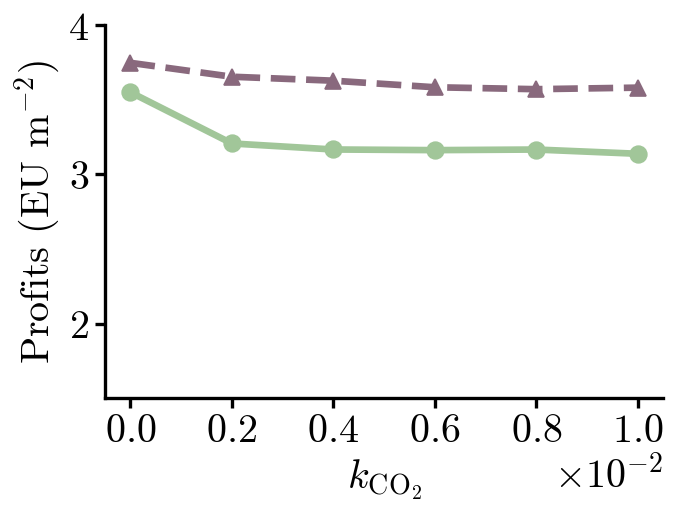

In [12]:
profit_ylim = (1.5, 4.0)
profit_label = r'Profits (EU m$^{-2}$)'
var_to_plot = 'Profits'
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)

additive_plot_params['fig'] = fig
additive_plot_params['ax'] = ax
additive_plot_params['var_to_plot'] = var_to_plot
additive_plot_params['ylabel'] = profit_label
additive_plot_params['ylim'] = profit_ylim


multiplicative_plot_params = additive_plot_params.copy()
multiplicative_plot_params['var_df'] = co2_multiplicative_means
multiplicative_plot_params['std_df'] = co2_multiplicative_stds
multiplicative_plot_params['color'] = multiplicative_color
multiplicative_plot_params['linestyle'] = multiplicative_linestyle
multiplicative_plot_params['marker'] = multiplicative_marker

fig, ax = plot_coef(**additive_plot_params)
fig, ax = plot_coef(**multiplicative_plot_params)

fig.tight_layout()
# fig.savefig('co2-profits.svg', format='svg') 
plt.show()

# Temperature

In [13]:
temp_additive_dfs  = load_data_folder(additive_data_path+'temp/')
temp_multiplicative_dfs  = load_data_folder(multiplicative_data_path+'temp/')

k-temp-0.0-666.csv
k-temp-0.4-666.csv
k-temp-0.8-666.csv
k-temp-1.2-666.csv
k-temp-1.6-666.csv
k-temp-2.0-666.csv
k-temp-0.0-666.csv
k-temp-0.4-666.csv
k-temp-0.8-666.csv
k-temp-1.2-666.csv
k-temp-1.6-666.csv
k-temp-2.0-666.csv


In [14]:
temp_variable = 'Temperature violation'
temp_coefficients = np.linspace(0, 2, num=6)
temp_additive_means, temp_additive_stds = compute_mean_std(temp_additive_dfs, temp_coefficients, temp_variable, Nexperimnts)
temp_multiplicative_means, temp_multiplicative_stds = compute_mean_std(temp_multiplicative_dfs, temp_coefficients, temp_variable, Nexperimnts)


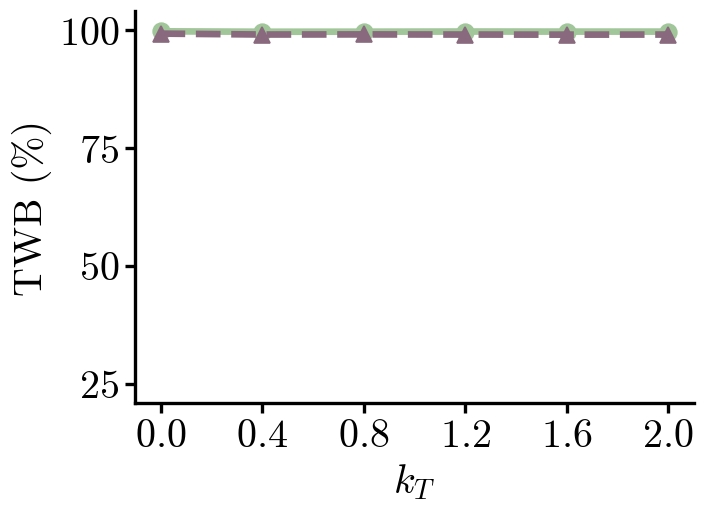

In [15]:
temp_marker_idx = None
temp_xlabel = r'$k_{T}$'
additive_color = cm.tokyoS(4)
multiplicative_color = cm.tokyoS(6)

additive_linestyle = 'o-'
multiplicative_linestyle = '^--'

co2_marker_idx = None

ylim = (20.952141203703697, 104)
var_to_plot = 'Time within boundary (%)'
co2_xlabel = r'$k_{\mathrm{CO}_2}$'

additive_marker = 'o'
multiplicative_marker = '^'

bound_ylabel = r'TWB (%)'

fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
additive_temp_plot_params = {'fig': fig, 'ax': ax, 'var_df': temp_additive_means, 'std_df': temp_additive_stds,'color': additive_color, 'var_to_plot': var_to_plot, 'xlabel': temp_xlabel, 'marker': additive_marker, 'ylabel':bound_ylabel, 'ylim':ylim, 'marker_idx': co2_marker_idx, 'linestyle': additive_linestyle, 'marker_idx': temp_marker_idx, 'linewidth': 4, 'markersize': 10, 'sci_notation': False, 'errorbar': False}


multiplicative_temp_plot_params = additive_temp_plot_params.copy()
multiplicative_temp_plot_params['var_df'] = temp_multiplicative_means
multiplicative_temp_plot_params['std_df'] = temp_multiplicative_stds
multiplicative_temp_plot_params['color'] = multiplicative_color
multiplicative_temp_plot_params['linestyle'] = multiplicative_linestyle
multiplicative_temp_plot_params['marker'] = multiplicative_marker

fig, ax = plot_coef(**additive_temp_plot_params)
fig, ax = plot_coef(**multiplicative_temp_plot_params)
fig.tight_layout()

# fig.savefig('temp-bounds.svg', format='svg')
plt.show()


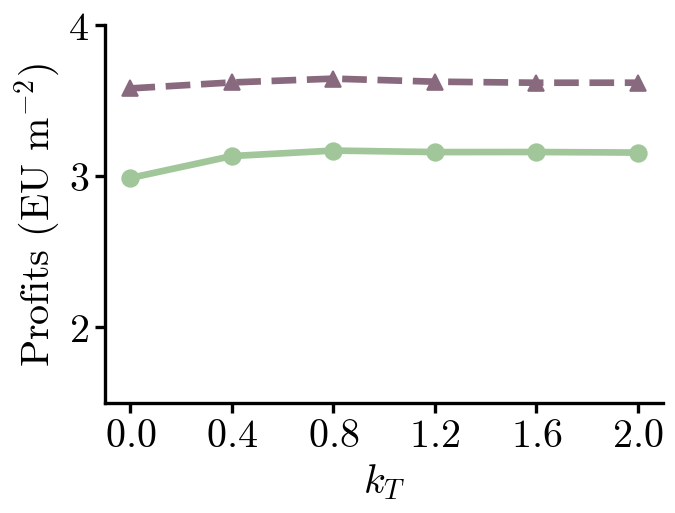

In [16]:
profit_ylim = (1.5, 4.0)
profit_label = r'Profits (EU m$^{-2}$)'
var_to_plot = 'Profits'
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)

additive_temp_plot_params['fig'] = fig
additive_temp_plot_params['ax'] = ax
additive_temp_plot_params['var_to_plot'] = var_to_plot
additive_temp_plot_params['ylabel'] = profit_label
additive_temp_plot_params['ylim'] = profit_ylim

multiplicative_temp_plot_params['fig'] = fig
multiplicative_temp_plot_params['ax'] = ax
multiplicative_temp_plot_params['var_to_plot'] = var_to_plot
multiplicative_temp_plot_params['ylabel'] = profit_label
multiplicative_temp_plot_params['ylim'] = profit_ylim


fig, ax = plot_coef(**additive_temp_plot_params)
fig, ax = plot_coef(**multiplicative_temp_plot_params)
fig.tight_layout()
# fig.savefig('temp-profits.svg', format='svg') 
plt.show()

# Relative Humidity

In [17]:
# load in data rh
rh_additive_dfs  = load_data_folder(additive_data_path+'rh/')
rh_multiplicative_dfs  = load_data_folder(multiplicative_data_path+'rh/')


k-rh-0.0-666.csv
k-rh-0.2-666.csv
k-rh-0.4-666.csv
k-rh-0.6-666.csv
k-rh-0.8-666.csv
k-rh-1.0-666.csv
k-rh-0.0-666.csv
k-rh-0.2-666.csv
k-rh-0.4-666.csv
k-rh-0.6-666.csv
k-rh-0.8-666.csv
k-rh-1.0-666.csv


In [18]:
rh_variable = 'Humidity violation'
rh_coefficients = np.linspace(0, 1, num=6)
rh_additive_means, rh_additive_stds = compute_mean_std(rh_additive_dfs, rh_coefficients, rh_variable, Nexperimnts)
rh_multiplicative_means, rh_multiplicative_stds = compute_mean_std(rh_multiplicative_dfs, rh_coefficients, rh_variable, Nexperimnts)


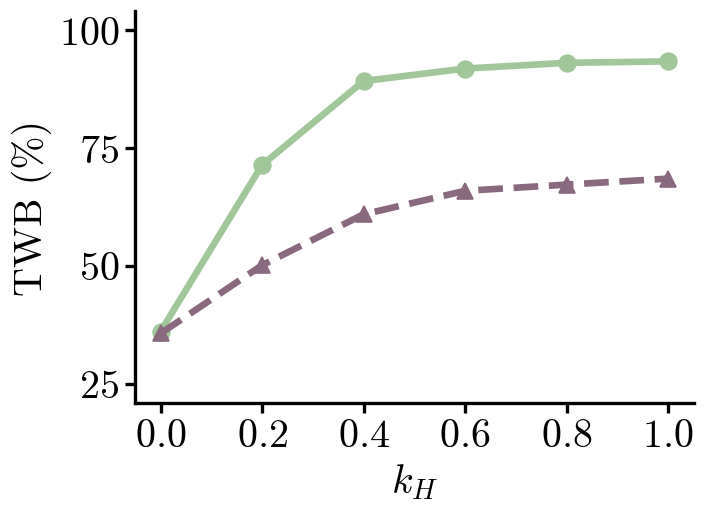

In [19]:
rh_marker_idx = None
rh_xlabel = r'$k_{H}$'
additive_color = cm.tokyoS(4)
multiplicative_color = cm.tokyoS(6)

additive_linestyle = 'o-'
multiplicative_linestyle = '^--'

ylim = (20.952141203703697, 104)
var_to_plot = 'Time within boundary (%)'
co2_xlabel = r'$k_{\mathrm{CO}_2}$'

additive_marker = 'o'
multiplicative_marker = '^'

bound_ylabel = r'TWB (%)'

fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
additive_rh_plot_params = {'fig': fig, 'ax': ax, 'var_df': rh_additive_means, 'std_df': rh_additive_stds,'color': additive_color, 'var_to_plot': var_to_plot, 'xlabel': rh_xlabel, 'marker': additive_marker, 'ylabel':bound_ylabel, 'ylim':ylim, 'marker_idx': co2_marker_idx, 'linestyle': additive_linestyle, 'marker_idx': rh_marker_idx, 'linewidth': 4, 'markersize': 10, 'sci_notation': False, 'errorbar': False}

multiplicative_rh_plot_params = additive_rh_plot_params.copy()
multiplicative_rh_plot_params['var_df'] = rh_multiplicative_means
multiplicative_rh_plot_params['std_df'] = rh_multiplicative_stds
multiplicative_rh_plot_params['color'] = multiplicative_color
multiplicative_rh_plot_params['linestyle'] = multiplicative_linestyle
multiplicative_rh_plot_params['marker'] = multiplicative_marker

fig, ax = plot_coef(**additive_rh_plot_params)
fig, ax = plot_coef(**multiplicative_rh_plot_params)
fig.tight_layout()
# fig.savefig('rh-bounds-compared.svg', format='svg')
plt.show()


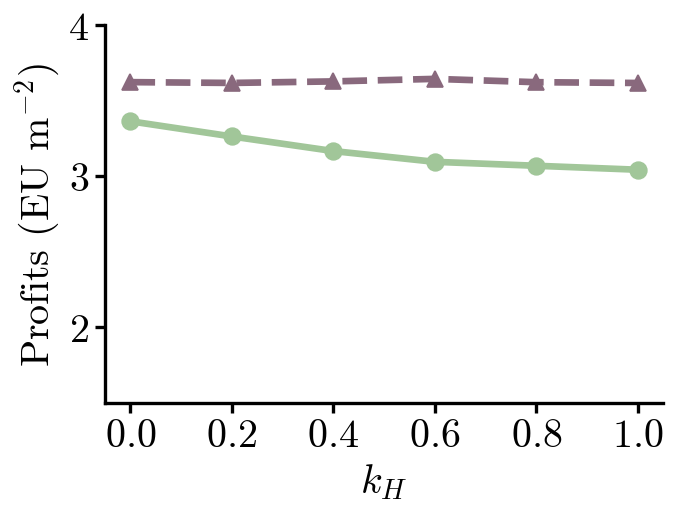

In [20]:
profit_ylim = (1.5, 4.0)
profit_label = r'Profits (EU m$^{-2}$)'
var_to_plot = 'Profits'
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)

additive_rh_plot_params['fig'] = fig
additive_rh_plot_params['ax'] = ax
additive_rh_plot_params['var_to_plot'] = var_to_plot
additive_rh_plot_params['ylabel'] = profit_label
additive_rh_plot_params['ylim'] = profit_ylim

multiplicative_rh_plot_params['fig'] = fig
multiplicative_rh_plot_params['ax'] = ax
multiplicative_rh_plot_params['var_to_plot'] = var_to_plot
multiplicative_rh_plot_params['ylabel'] = profit_label
multiplicative_rh_plot_params['ylim'] = profit_ylim


fig, ax = plot_coef(**additive_rh_plot_params)
fig, ax = plot_coef(**multiplicative_rh_plot_params)
fig.tight_layout()
# fig.savefig('rh-profits-compared.svg', format='svg') 
plt.show()

In [22]:
rh_multiplicative_means

,Profits,Time within boundary (%),Humidity violation (ppm),ki
0,3.623708,35.672454,4.745857,0.0
1,3.618491,50.151042,3.851762,0.2
2,3.628618,60.958333,3.322520,0.4
3,3.645278,65.937500,3.070714,0.6
4,3.623372,67.254051,2.965615,0.8
5,3.618176,68.526620,2.923097,1.0
